# Advanced Lane Finding Project

This notebook shows the full pipeline of the lane detection on a video.


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import time
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Loading the camera calibration
cameraCalib = pickle.load(open('serialized_camera_calibration/camera_calibration.p','rb'))
mtx, dist = map(cameraCalib.get, ('mtx','dist'))

# Loading perspective transformation matrices
t_matrices = pickle.load(open('perspective_xform_calibration/pt_calibration.p','rb'))
M, inv_M = map(t_matrices.get, ('M','inv_M'))

In [2]:
# Loading all test images for testing
images = glob.glob('../test_images/*.jpg')
img = list(map(lambda imageFileName: (imageFileName, cv2.cvtColor(cv2.imread(imageFileName),cv2.COLOR_BGR2RGB)), images))

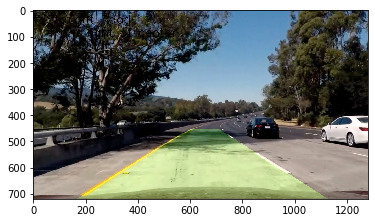

In [17]:
old_l_eq = np.empty(3)
old_r_eq = np.empty(3)
old_left_fit_m = np.empty(3)
old_right_fit_m = np.empty(3)
                         
def process_image(image):
    global old_l_eq
    global old_r_eq
    global old_left_fit_m
    global old_right_fit_m
    
    # Global user input variables
    height_percentage = 0.65
    btm_width_offset = 0.14
    top_width_offset = 0.44
    sobel_kernel = 3
    tmin = 12                       # Threshold min for edge detect
    tmax = 255                      # Threshold max for edge detect
    nwindows = 9                    # Number of sliding windows for lane line detect
    margin = 90                     # Window size
    minpx = 50                      # Number of min px encountered before calling it a legit lane line
    ym_per_px = 30/720              # meters per pixel in y dimension
    xm_per_px = 3.7/700             # meters per pixel in x dimension
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1.5
    fontColor = (0, 0, 0)
    histo_offset = 0.25
    
    # Global fixed variables
    height = image.shape[0]
    width = image.shape[1]
    lower_white = np.array([200,200,200], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8) 
    lower_yellow = np.array([96,50,20], dtype=np.uint8)
    upper_yellow = np.array([115,220,255], dtype=np.uint8)
    
    # Undistort the image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    # Set a duplicate for image processing
    duplicate = undist
    
    # Color thresholding for white and yellow
    hsv = cv2.cvtColor(duplicate, cv2.COLOR_BGR2HSV)
    mask_white = cv2.inRange(duplicate, lower_white, upper_white)
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    combined = cv2.addWeighted(mask_white,1,mask_yellow,1,0)
    binary_img = np.zeros_like(combined)
    binary_img[(combined >= 200) & (combined <= 255)] = 1
    
    # Applying perspective transformation
    transform = cv2.warpPerspective(binary_img, M, (width,height))
    
    # Finding the base lane line
    # Take a histogram of the bottom 40%, this means add all column into one array
    # eg [69 64 64 ... 0 0 0]
    histogram = np.sum(transform[int(transform.shape[0]*0.4):,:], axis=0)

    # These will be the starting point for the left and right lines
    width = np.int(histogram.shape[0])
    left_base = np.argmax(histogram[:np.int(histo_offset*width)])
    right_base = np.argmax(histogram[-1*np.int(histo_offset*width):]) + np.int(width*(1-histo_offset))
    
    # Set height of windows
    window_height = np.int(transform.shape[0] / nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    # nonzero() function returns tuple of ([row_index],[col_index]) of non zero elements
    nonzero = transform.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # To store the left and right lane pixel indices
    left_lane_ind = []
    right_lane_ind = []
    
    # Current left and right position
    current_left = left_base
    current_right = right_base
    
    ## FOR DEBUGGING
    # np.dstack() function stacks arrays in sequence depth wise
    #out_img = np.dstack((transform, transform, transform)) * 255
        
    for i in range(nwindows):
            
        # Identify window boundaries in x and y
        win_y_low = height - (i+1)*window_height
        win_y_high = height - i*window_height
        win_xleft_low = current_left - margin
        win_xleft_high = current_left + margin
        win_xright_low = current_right - margin
        win_xright_high = current_right + margin
            
        # Identify the nonzero pixels in x and y within the window
        valid_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        valid_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # FOR DEBUGGING
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,0,255), 2)
             
        # Append these indices to the lists
        left_lane_ind.append(valid_left_inds)
        right_lane_ind.append(valid_right_inds)
            
        # If you found > minpx pixels, recenter next window on their mean position
        if len(valid_left_inds) > minpx:
            current_left = np.int(np.mean(nonzerox[valid_left_inds]))
        if len(valid_right_inds) > minpx:        
            current_right = np.int(np.mean(nonzerox[valid_right_inds]))
    
    # FOR DEBUGGING
    #return out_img

    # Concatenate the arrays of indices
    left_lane_ind = np.concatenate(left_lane_ind)
    right_lane_ind = np.concatenate(right_lane_ind)
        
    if len(left_lane_ind) == 0 or len(right_lane_ind) == 0:
        l_eq = old_l_eq
        r_eq = old_r_eq
        left_fit_m = old_left_fit_m
        right_fit_m = old_right_fit_m
    else:   
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_ind]
        lefty = nonzeroy[left_lane_ind] 
        rightx = nonzerox[right_lane_ind]
        righty = nonzeroy[right_lane_ind]
    
        # Fit a second order polynomial to each
        l_eq = np.polyfit(lefty, leftx, 2)
        r_eq = np.polyfit(righty, rightx, 2)
        
        # Fit a second order polynomial to each
        left_fit_m = np.polyfit(lefty*ym_per_px, leftx*xm_per_px, 2)
        right_fit_m = np.polyfit(righty*ym_per_px, rightx*xm_per_px, 2)
        
        if abs(l_eq[0] - r_eq[0]) > 0.0005:
            l_eq = old_l_eq
            r_eq = old_r_eq
            left_fit_m = old_left_fit_m
            right_fit_m = old_right_fit_m
    
    
    # Lane curvature calculation
    l_curvature = ((1 + (2*left_fit_m[0]*(height-1)*ym_per_px + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    r_curvature = ((1 + (2*right_fit_m[0]*(height-1)*ym_per_px + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    
    # Inverse perspective transform
    y = np.linspace(0, height - 1, height)
    color_warp = np.zeros_like(duplicate).astype(np.uint8)
    
    # Calculate points.
    left_x = l_eq[0]*y**2 + l_eq[1]*y + l_eq[2]
    right_x = r_eq[0]*y**2 + r_eq[1]*y + r_eq[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_x, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x, y])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (85,200,12))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(color_warp, inv_M, (width, height))
    unwrap = cv2.addWeighted(duplicate, 1, unwarp, 0.3, 0)
    
    # Calculate vehicle center and display information
    width = width*xm_per_px
    height = height*ym_per_px
    center = width / 2
    lineLeft = left_fit_m[0]*height**2 + left_fit_m[1]*height + left_fit_m[2]
    lineRight = right_fit_m[0]*height**2 + right_fit_m[1]*height + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = (lineMiddle - center) * 100
    
    if diffFromVehicle > 0:
        message = '{:.0f} cm right'.format(diffFromVehicle)
    else:
        message = '{:.0f} cm left'.format(-diffFromVehicle)
    
    if (l_curvature > 1000) or (r_curvature > 1000):
        cv2.putText(unwrap, 'Straight Road', (50, 50), font, fontScale, fontColor, 2)
    else:
        if l_eq[0] > 0 : turn_msg = 'Turn Right with Curvature'
        else: turn_msg = 'Turn Left with Curvature'
        cv2.putText(unwrap, '{}: {:.0f} m'.format(turn_msg,(l_curvature+r_curvature)//2), (50, 50), font, fontScale, fontColor, 2)
    
    cv2.putText(unwrap, '{} of center'.format(message), (50, 100), font, fontScale, fontColor, 2)
    
    old_l_eq = l_eq
    old_r_eq = r_eq
    old_left_fit_m = left_fit_m
    old_right_fit_m = right_fit_m
    return unwrap

plt.imshow(process_image(img[6][1]),cmap='gray')

In [13]:
white_output = '../o_malaysia.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip('../malaysia.mp4').subclip(448,460)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

t:   1%|▌                                                                    | 3/360 [00:00<00:13, 25.93it/s, now=None]

Moviepy - Building video ../o_malaysia.mp4.
Moviepy - Writing video ../o_malaysia.mp4



Moviepy - Done !
Moviepy - video ready ../o_malaysia.mp4
Wall time: 34.5 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))